# Setup

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

## Caricamento dataset

In [9]:
df = pd.read_csv("../data/processed/preprocessed_data.csv", encoding='latin1')
df.head()

,label,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",accord gran compani plan move product russia a...
1,neutral,Technopolis plans to develop in stages an area...,technopoli plan develop stage area less squar ...
2,negative,The international electronic industry company ...,intern electron industri compani elcoteq laid ...
3,positive,With the new production plant the company woul...,new product plant compani would increas capac ...
4,positive,According to the company 's updated strategy f...,accord compani updat strategi year baswar targ...


## Distribuzione della lunghezza del testo (dataset preprocessato)

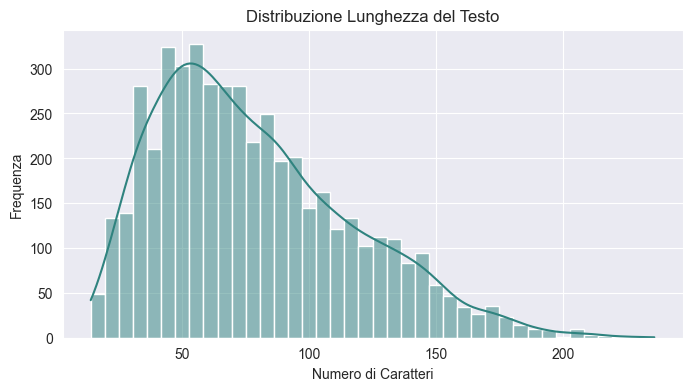

Statistiche sulla lunghezza delle frasi:
Media della lunghezza delle frasi: 78.34
Mediana della lunghezza delle frasi: 71.0
Lunghezza minima delle frasi: 14
Lunghezza massima delle frasi: 236


In [10]:
df['text_len'] = df['cleaned_text'].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=40, kde=True, color='#2f837f')
plt.title("Distribuzione Lunghezza del Testo")
plt.xlabel("Numero di Caratteri")
plt.ylabel("Frequenza")
plt.show()
print("Statistiche sulla lunghezza delle frasi:")
print(f"Media della lunghezza delle frasi: {df['text_len'].mean():.2f}")
print(f"Mediana della lunghezza delle frasi: {df['text_len'].median()}")
print(f"Lunghezza minima delle frasi: {df['text_len'].min()}")
print(f"Lunghezza massima delle frasi: {df['text_len'].max()}")

## Boxplot per la lunghezza delle frasi (in numero di caratteri)

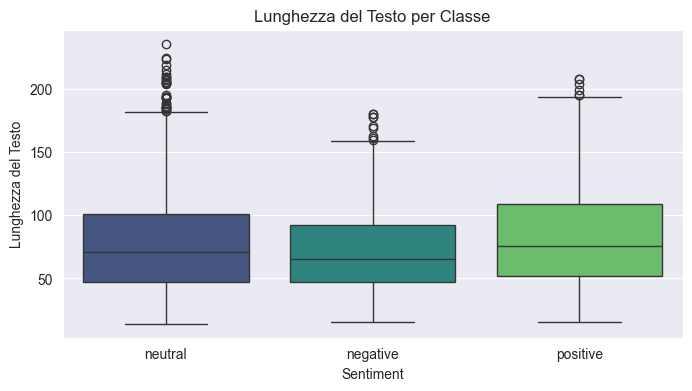


Classe: neutral
Numero di outlier: 31
Media: 77.36
Mediana: 71.0
Min: 14
Max: 236

Classe: negative
Numero di outlier: 9
Media: 73.13
Mediana: 65.0
Min: 15
Max: 180

Classe: positive
Numero di outlier: 6
Media: 82.70
Mediana: 76.0
Min: 15
Max: 208


In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='label', hue='label',y='text_len', palette='viridis')
plt.title("Lunghezza del Testo per Classe")
plt.xlabel("Sentiment")
plt.ylabel("Lunghezza del Testo")
plt.show()


for label in df['label'].unique():
    subset = df[df['label'] == label]
    Q1 = subset['text_len'].quantile(0.25)
    Q3 = subset['text_len'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    label_outliers = subset[(subset['text_len'] < lower_bound) | (subset['text_len'] > upper_bound)]

    print(f"\nClasse: {label}")
    print(f"Numero di outlier: {label_outliers.shape[0]}")
    print(f"Media: {subset['text_len'].mean():.2f}")
    print(f"Mediana: {subset['text_len'].median()}")
    print(f"Min: {subset['text_len'].min()}")
    print(f"Max: {subset['text_len'].max()}")


## Violion plot per il confronto tra i due dataset (originale-preprocessato)

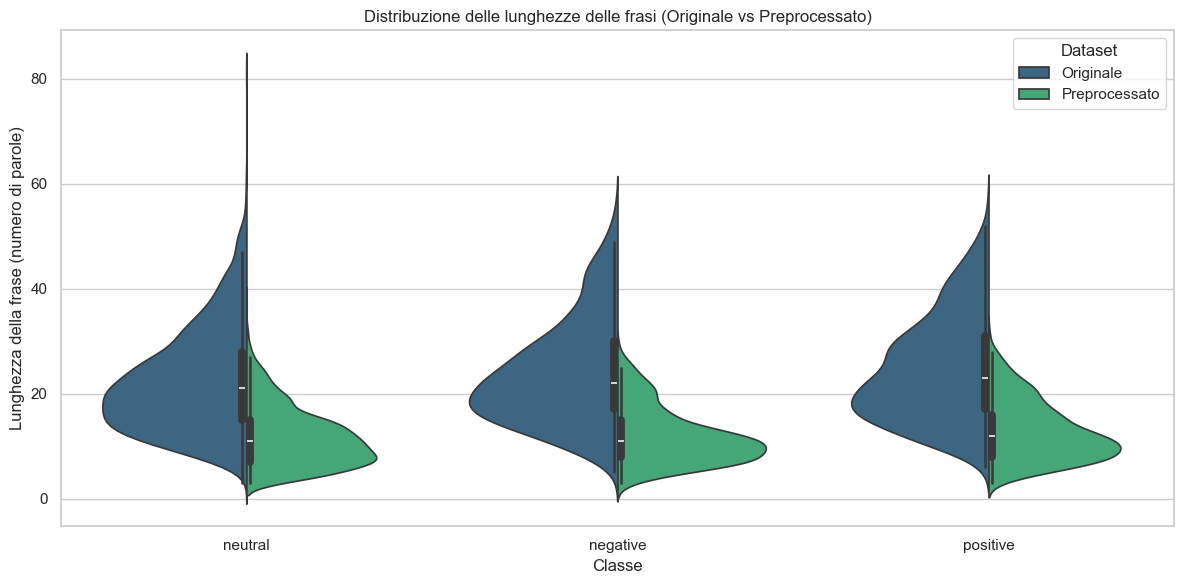

Classe: neutral
  - Originale: media=22.33, mediana=21.0, max=81, min=3
  - Preprocessato: media=11.74, mediana=11.0, max=38, min=3

Classe: negative
  - Originale: media=23.94, mediana=22.0, max=56, min=5
  - Preprocessato: media=11.88, mediana=11.0, max=29, min=3

Classe: positive
  - Originale: media=24.72, mediana=23.0, max=57, min=6
  - Preprocessato: media=12.88, mediana=12.0, max=32, min=3



In [12]:
# Calcolo lunghezza (in numero di parole) delle frasi originali e preprocessate
df['length_original'] = df['text'].apply(str).apply(lambda x: len(x.split()))
df['length_preprocessed'] = df['cleaned_text'].apply(str).apply(lambda x: len(x.split()))

#  DataFrame per il confronto
df_original = df[['label', 'length_original']].rename(columns={'length_original': 'length'})
df_original['dataset'] = 'Originale'

df_preprocessed = df[['label', 'length_preprocessed']].rename(columns={'length_preprocessed': 'length'})
df_preprocessed['dataset'] = 'Preprocessato'

# Unione dei due dataset
combined_df = pd.concat([df_original, df_preprocessed])


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.violinplot(data=combined_df, x='label', y='length', hue='dataset', split=True, palette="viridis")

plt.title("Distribuzione delle lunghezze delle frasi (Originale vs Preprocessato)")
plt.xlabel("Classe")
plt.ylabel("Lunghezza della frase (numero di parole)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

for label in combined_df['label'].unique():
    orig = df_original[df_original['label'] == label]['length']
    prep = df_preprocessed[df_preprocessed['label'] == label]['length']
    print(f"Classe: {label}")
    print(f"  - Originale: media={orig.mean():.2f}, mediana={orig.median()}, max={orig.max()}, min={orig.min()}")
    print(f"  - Preprocessato: media={prep.mean():.2f}, mediana={prep.median()}, max={prep.max()}, min={prep.min()}")
    print()

**Classe Neutrale**
- Originale: La lunghezza media delle frasi nella classe "neutral" è di circa 22 parole, con una mediana di 21. La lunghezza minima è di 2 parole e la massima di 81. Il numero di frasi che si trovano al di fuori del range interquartile (outliers) è 27, indicando una certa variabilità nelle frasi, che può essere dovuta a frasi molto lunghe o molto corte.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi si riduce significativamente a circa 11 parole, con una mediana di 11. La lunghezza minima delle frasi è di 1 parola e la massima di 38. Anche qui ci sono ancora dei valori estremi (outliers) ma in numero inferiore (27). Il preprocessing ha quindi compresso le frasi, probabilmente rimuovendo parole non necessarie o ridondanti

**Classe Negativa**
-  Originale: Nella classe "negative", le frasi originali hanno una lunghezza media di 24 parole, con una mediana di 22. La lunghezza minima delle frasi è di 5 parole e la massima di 56. Gli outliers in questa classe sono 10, suggerendo una variabilità notevole, probabilmente dovuta a frasi lunghe e complesse.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi scende a circa 12 parole, con una mediana di 11. La lunghezza minima è di 2 parole e la massima di 29. Anche qui, i valori estremi sono stati ridotti, il che conferma che il preprocessing ha ridotto il numero di parole in modo significativo. La diminuzione della lunghezza potrebbe indicare che parole non essenziali o stop words sono state eliminate.

**Classe Positiva**
-  Originale: Per la classe "positive", la lunghezza media delle frasi è di circa 25 parole, con una mediana di 23. La lunghezza minima è di 5 parole e la massima di 57. Anche in questa classe ci sono 7 outliers, segnalando un'alta variabilità.
- Preprocessato: Dopo il preprocessing, la lunghezza media delle frasi scende a 13 parole, con una mediana di 12. La lunghezza minima è di 2 parole e la massima di 32. Il preprocessing ha di nuovo ridotto la lunghezza delle frasi, mantenendo comunque un range di lunghezze che si spinge fino a 32 parole. Come nelle altre classi, le frasi sono state sensibilmente abbreviate.

Il preprocessing ha ridotto la lunghezza media delle frasi in tutte e tre le classi (neutral, negative, positive), con una media che passa da circa 23-25 parole a circa 12-13 parole.

**Outliers**: Anche se il numero di outliers è diminuito in modo generale, ci sono ancora alcuni valori estremi che indicano che ci sono frasi particolarmente lunghe o corte, ma in misura minore rispetto al dataset originale. Successivamente sono state analizzate le frasi con meno di 2 parole

**Effetto del preprocessing**: In generale, il preprocessing sembra aver rimosso molte parole non essenziali, riducendo la lunghezza delle frasi, probabilmente eliminando stop words o parole irrilevanti, e lasciando solo il contenuto più significativo. Questo è positivo per migliorare l'efficienza in modelli NLP (elaborazione del linguaggio naturale), in quanto riduce la "rumorosità" dei dati.


# Distribuzione vocaboli Dataset Originale - Prepocessato


 Vocaboli unici PRIMA del preprocessing: 10063
 Vocaboli unici DOPO il preprocessing: 7078

 Distribuzione classi NEL DATASET:
label
neutral     2852
positive    1361
negative     603
Name: count, dtype: int64


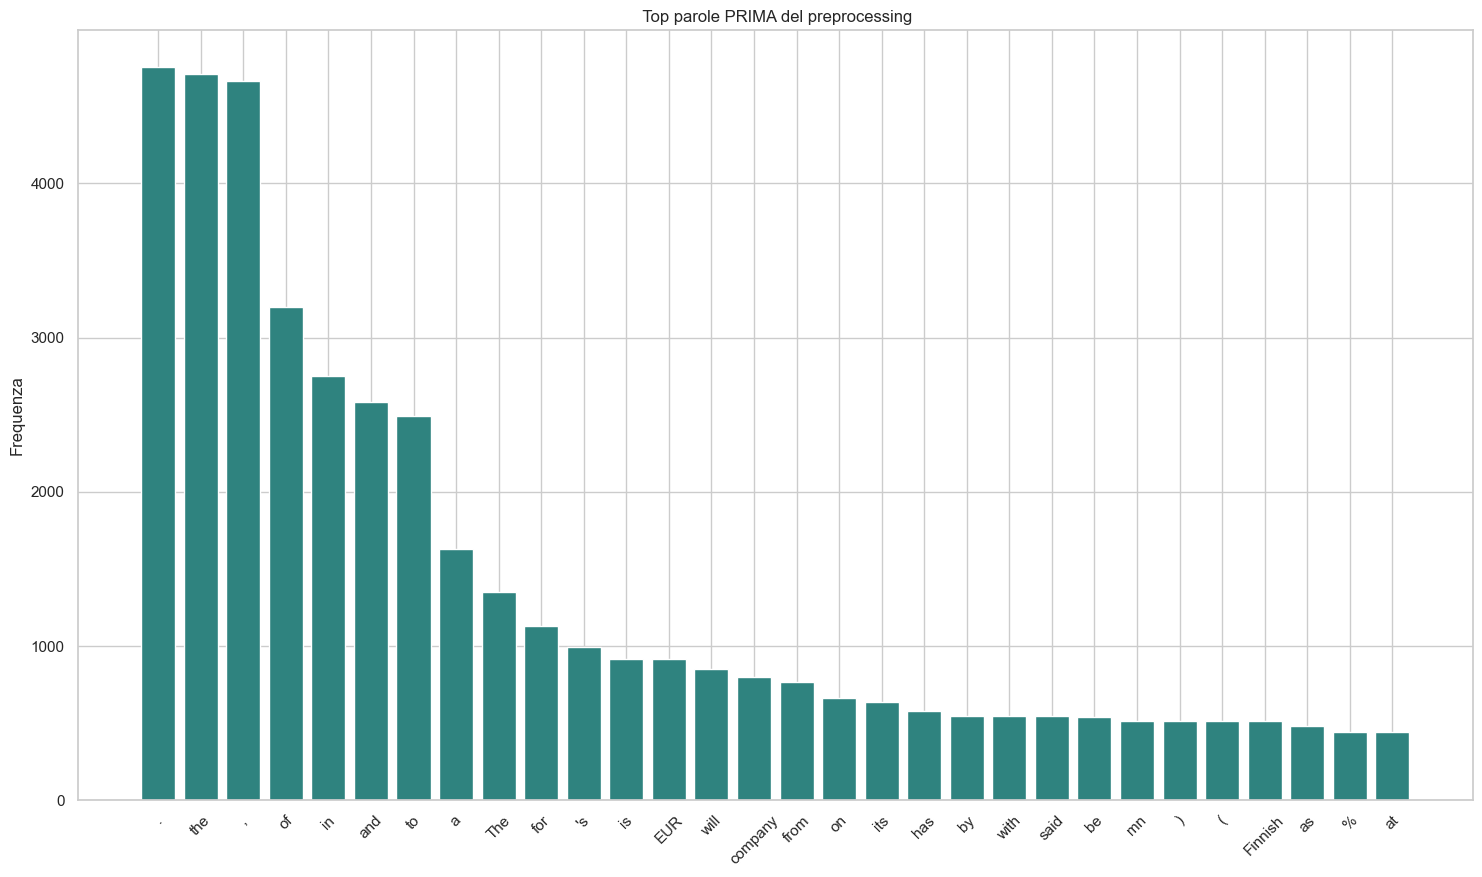

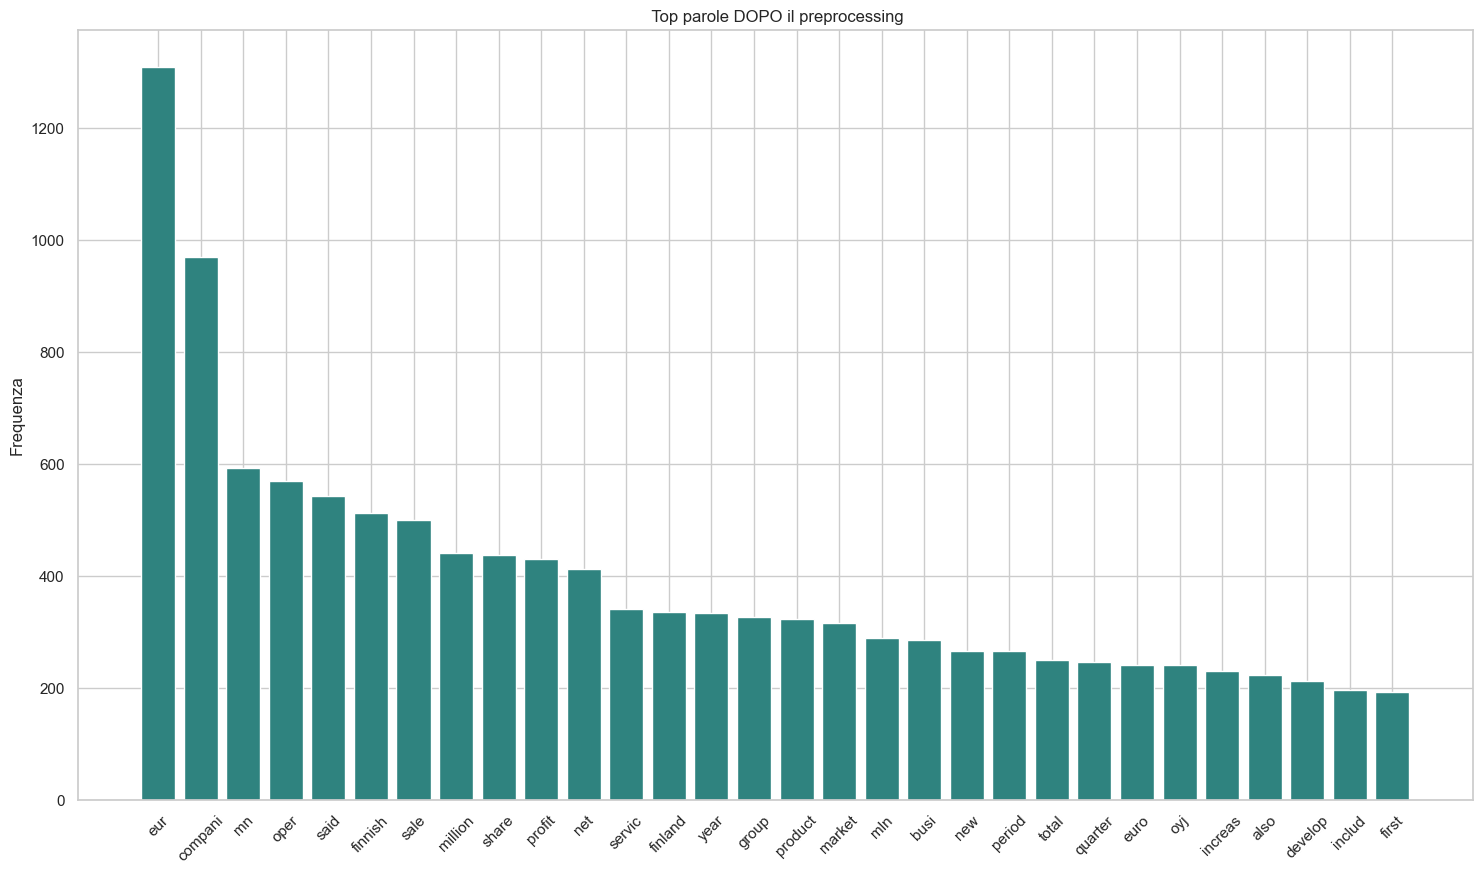

In [14]:
df = pd.read_csv("../data/processed/preprocessed_data.csv")

# Conto dei vocaboli unici prima e dopo il preprocessing
vectorizer_original = CountVectorizer()
vectorizer_cleaned = CountVectorizer()

vocab_original = vectorizer_original.fit(df['text']).get_feature_names_out()
vocab_cleaned = vectorizer_cleaned.fit(df['cleaned_text']).get_feature_names_out()

print(f"\n Vocaboli unici PRIMA del preprocessing: {len(vocab_original)}")
print(f" Vocaboli unici DOPO il preprocessing: {len(vocab_cleaned)}")

# DISTRIBUZIONE DELLE CLASSI
print("\n Distribuzione classi NEL DATASET:")
print(df['label'].value_counts())


# PAROLE PIÙ FREQUENTI PRIMA e DOPO ###

# Funzione per visualizzare le top parole
def plot_top_words(texts, title, n=30):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    common = word_counts.most_common(n)
    words, counts = zip(*common)

    plt.figure(figsize=(18,10))
    plt.bar(words, counts, color='#2f837f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Frequenza")
    plt.show()

# Visualizza le parole più frequenti prima del preprocessing
plot_top_words(df['text'], " Top parole PRIMA del preprocessing")

# Visualizza le parole più frequenti dopo il preprocessing
plot_top_words(df['cleaned_text'], " Top parole DOPO il preprocessing")


## Distrubuzione dei vocaboli Unici - per classe

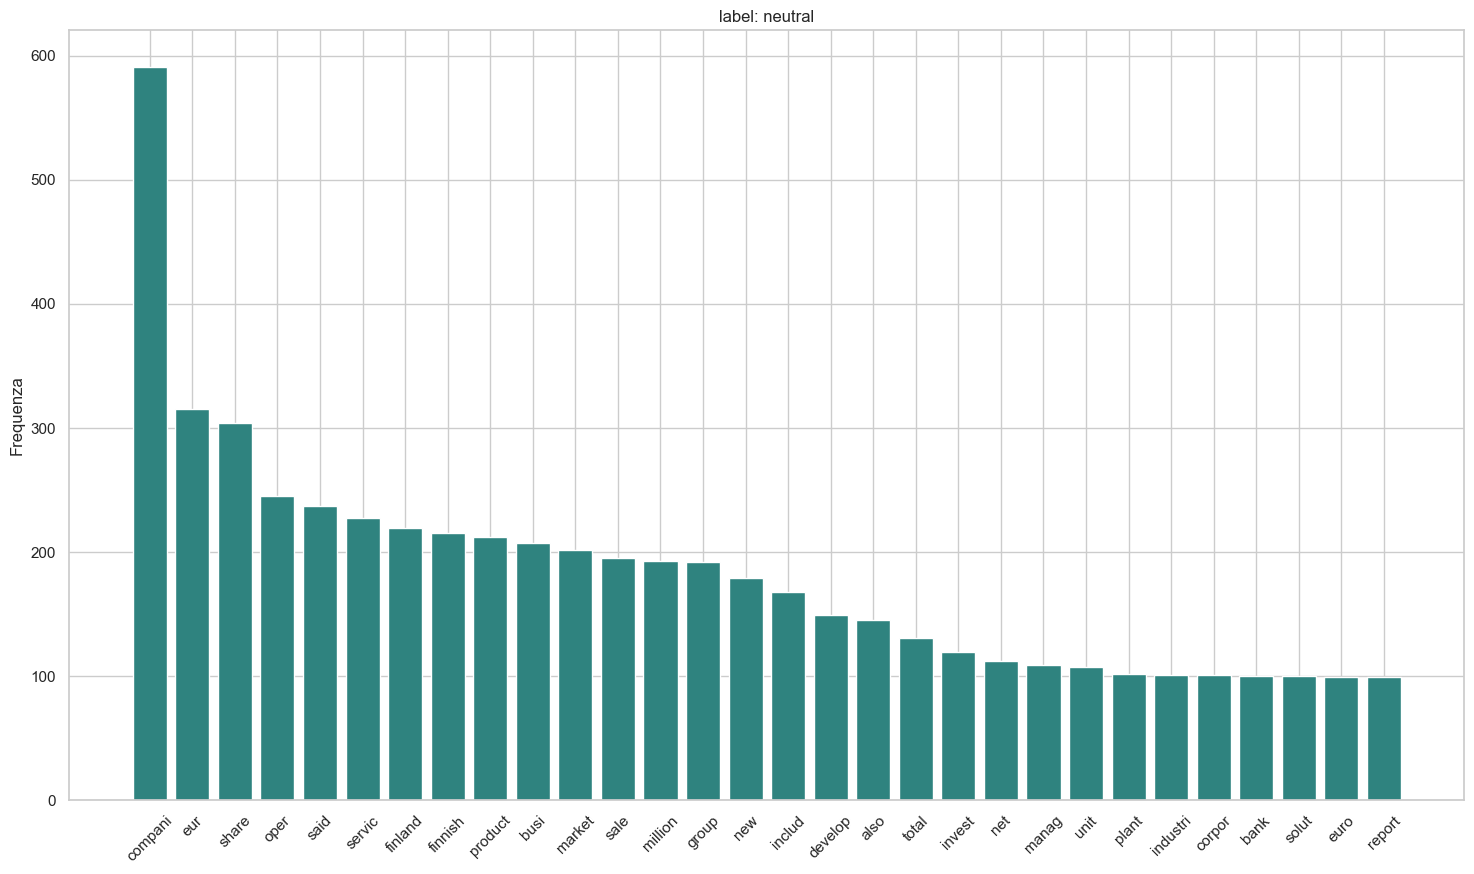

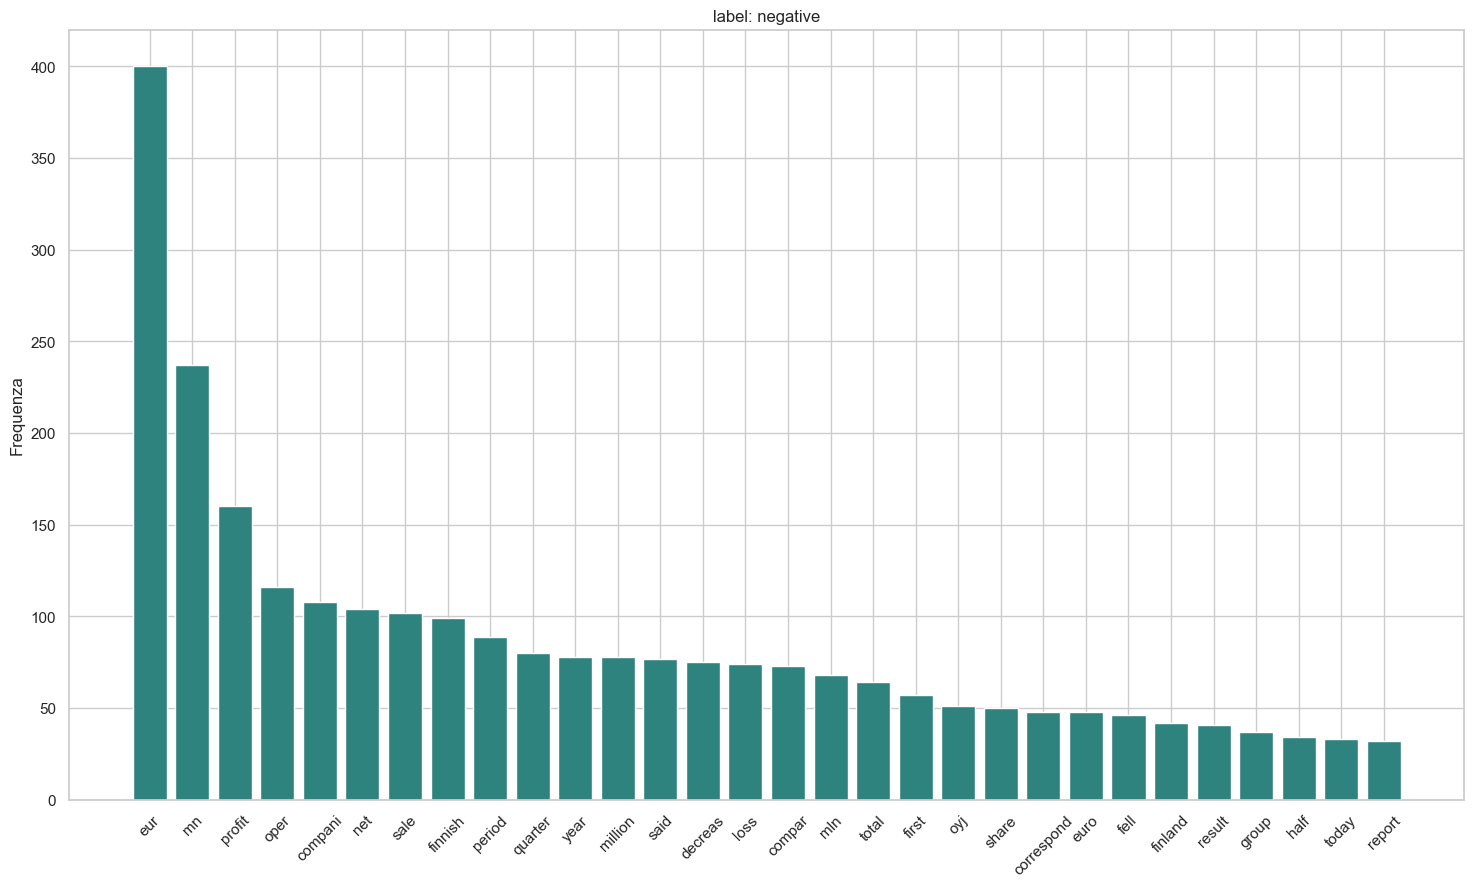

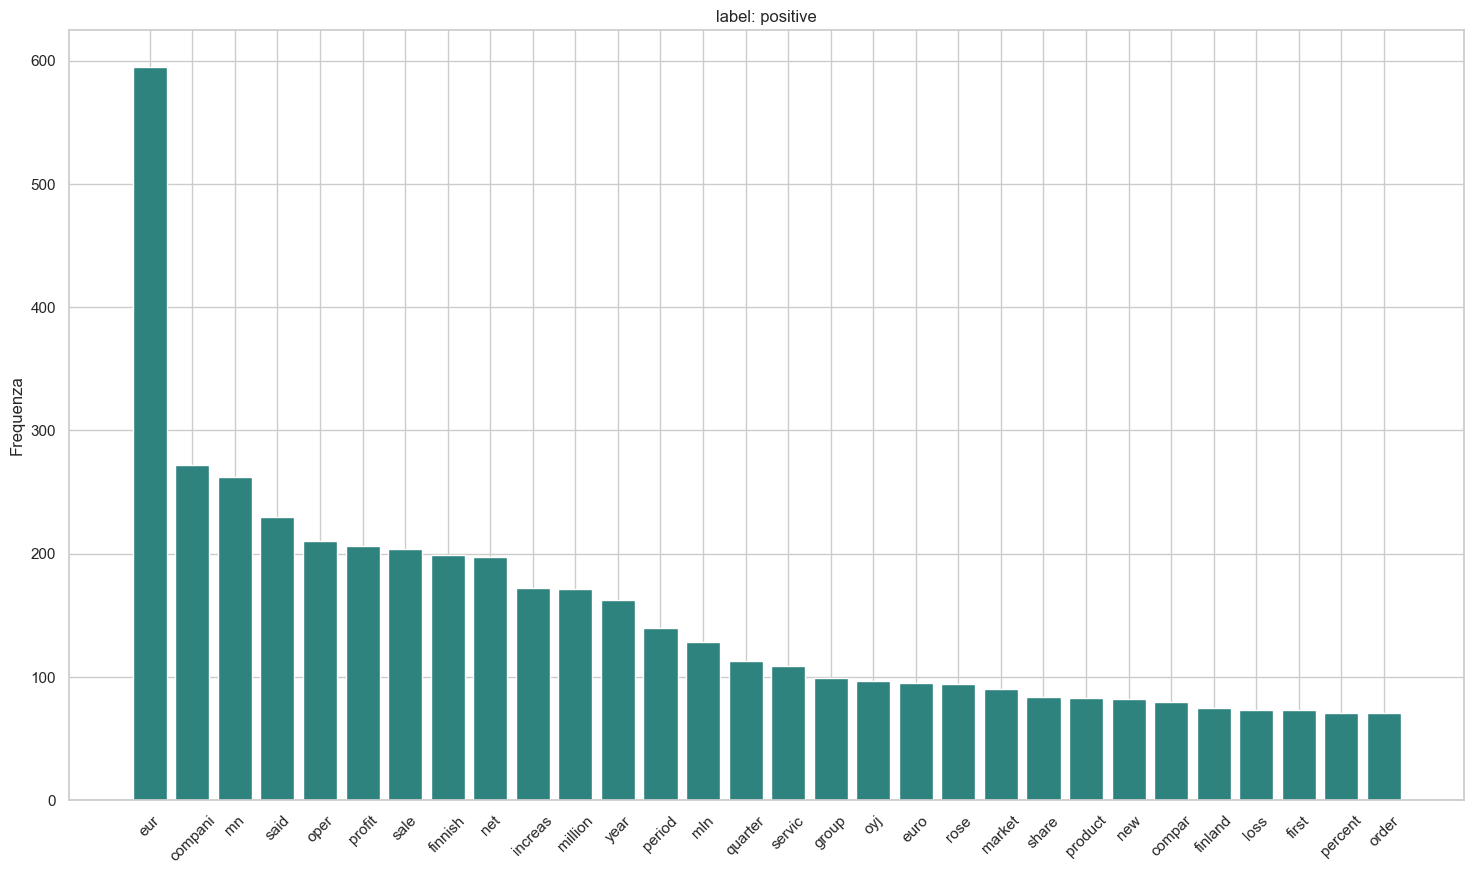

In [23]:
df = pd.read_csv("../data/processed/preprocessed_data.csv")

vocab_cleaned = vectorizer_cleaned.fit(df['cleaned_text']).get_feature_names_out()
def plot_top_words(texts, title, n=30):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    common = word_counts.most_common(n)
    words, counts = zip(*common)

    plt.figure(figsize=(18, 10))
    plt.bar(words, counts, color='#2f837f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Frequenza")
    plt.show()

    return [word for word, count in common]

# Dizionario per salvare parole top per ogni label
top_words_per_label = {}

for label in df['label'].unique():
    texts_for_label = df[df['label'] == label]['cleaned_text']
    top_words = plot_top_words(texts_for_label, title=f"label: {label}")
    top_words_per_label[label] = top_words


**Classe Neutrale**
- Parole come oper, servic, product, group, invest, bank, solut, industri sembrano indicare testi descrittivi o neutrali, con focus su attività operative, prodotti e servizi, senza forte connotazione emotiva.

**Classe Negativa**
 - Sono presenti parole che indicano calo o perdita: decreas, loss, fell, compar, loss, quarter, period – che suggeriscono comunicazioni con notizie negative, come perdite o risultati inferiori alle aspettative.

**Classe Positiva**
  - Parole come increas, rose, order, percent indicano miglioramenti, crescita e risultati positivi. C’è anche profit e market in senso positivo associato a termini di guadagno.